# Importing the used libraries

In [1]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

# Classifying the used datasets

In [2]:
data_dir = "../input/original-dataset/PlantaeK dataset classified/test"
Num_classes = os.listdir(data_dir)
print(Num_classes)
print("Total Number of classes are: {}".format(len(Num_classes)))

['GRAPES_healthy', 'PEAR_diseased', 'WALNUT_healthy', 'CHERRY_diseased', 'CHERRY_healthy', 'CRANBERRY_healthy', 'PEACH_diseased', 'PEACH_healthy', 'Apple_healthy', 'APRICOT_healthy', 'WALNUT_diseased', 'Apple_diseased', 'APRICOT_diseased', 'CRANBERRY_diseased', 'GRAPES_diseased', 'PEAR_healthy']
Total Number of classes are: 16


In [3]:
plant_species_class_size = {}
for species in Num_classes:
    plant_species_class_size[species] = len(os.listdir(data_dir + '/' + species))

Text(0.5, 1.0, 'Images per each class of plant species')

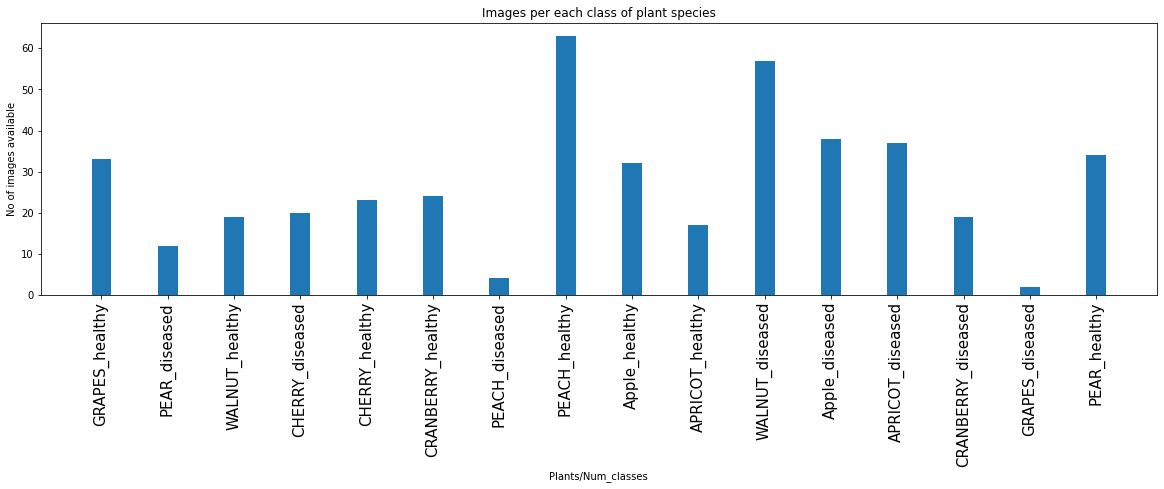

In [4]:
index = [n for n in range(16)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in plant_species_class_size.values()], width=0.3)
plt.xlabel('Plants/Num_classes', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, Num_classes, fontsize=15, rotation=90)
plt.title('Images per each class of plant species')

## Data Preprocessing

In [5]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '../input/original-dataset/PlantaeK dataset classified'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

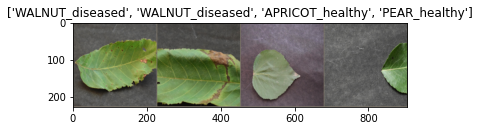

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

## Define a function for training and evaluating the model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## Downloading the pretrained models

# VGG-16 Architecture

In [9]:
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.5753 Acc: 0.5233
val Loss: 1.5500 Acc: 0.5314

Epoch 1/19
----------
train Loss: 1.2784 Acc: 0.6030
val Loss: 1.0916 Acc: 0.5943

Epoch 2/19
----------
train Loss: 1.1767 Acc: 0.6308
val Loss: 1.3488 Acc: 0.6171

Epoch 3/19
----------
train Loss: 1.1571 Acc: 0.6574
val Loss: 1.1358 Acc: 0.6857

Epoch 4/19
----------
train Loss: 1.1016 Acc: 0.6665
val Loss: 1.1781 Acc: 0.6343

Epoch 5/19
----------
train Loss: 1.1307 Acc: 0.6554
val Loss: 1.4579 Acc: 0.6229

Epoch 6/19
----------
train Loss: 1.1518 Acc: 0.6522
val Loss: 1.3991 Acc: 0.6229

Epoch 7/19
----------
train Loss: 0.9296 Acc: 0.7001
val Loss: 1.2789 Acc: 0.6800

Epoch 8/19
----------
train Loss: 0.8773 Acc: 0.7092
val Loss: 1.1552 Acc: 0.6743

Epoch 9/19
----------
train Loss: 0.8787 Acc: 0.7137
val Loss: 1.1908 Acc: 0.6800

Epoch 10/19
----------
train Loss: 0.9128 Acc: 0.6982
val Loss: 1.2321 Acc: 0.6686

Epoch 11/19
----------
train Loss: 0.8716 Acc: 0.7092
val Loss: 1.1672 Acc: 0.6914

Ep

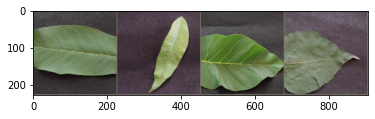

GroundTruth:  WALNUT_healthy, PEACH_healthy, WALNUT_healthy, APRICOT_diseased
Predicted:  WALNUT_healthy, PEACH_healthy, WALNUT_healthy, APRICOT_diseased


In [13]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))
images = images.to(device)
labels = images.to(device)
output = model_vgg16(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in predicted))

In [ ]:
plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('steps')
    plt.plot(best_acc)
    plt.show()